In [1]:
# %%
import pandas as pd
import os 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math 
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import boxcox

In [2]:
# %%
# Load the dataset
file_path = "../data/nberces5818v1_n2012.csv"
df = pd.read_csv(file_path)

# Display basic info about the dataset
df.info()

# %%
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

# %%
# Summary statistics
summary_stats = df.describe()

print(summary_stats)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22204 entries, 0 to 22203
Data columns (total 24 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   naics    22204 non-null  int64  
 1   year     22204 non-null  int64  
 2   emp      22087 non-null  float64
 3   pay      22087 non-null  float64
 4   prode    22087 non-null  float64
 5   prodh    22087 non-null  float64
 6   prodw    22087 non-null  float64
 7   vship    22087 non-null  float64
 8   matcost  22087 non-null  float64
 9   vadd     22087 non-null  float64
 10  invest   21723 non-null  float64
 11  invent   22087 non-null  float64
 12  energy   22087 non-null  float64
 13  cap      21359 non-null  float64
 14  equip    21359 non-null  float64
 15  plant    21359 non-null  float64
 16  piship   22087 non-null  float64
 17  pimat    22087 non-null  float64
 18  piinv    21359 non-null  float64
 19  pien     22087 non-null  float64
 20  dtfp5    20995 non-null  float64
 21  tfp5     213

In [3]:
# %%
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

naics         0
year          0
emp         117
pay         117
prode       117
prodh       117
prodw       117
vship       117
matcost     117
vadd        117
invest      481
invent      117
energy      117
cap         845
equip       845
plant       845
piship      117
pimat       117
piinv       845
pien        117
dtfp5      1209
tfp5        845
dtfp4      1209
tfp4        845
dtype: int64


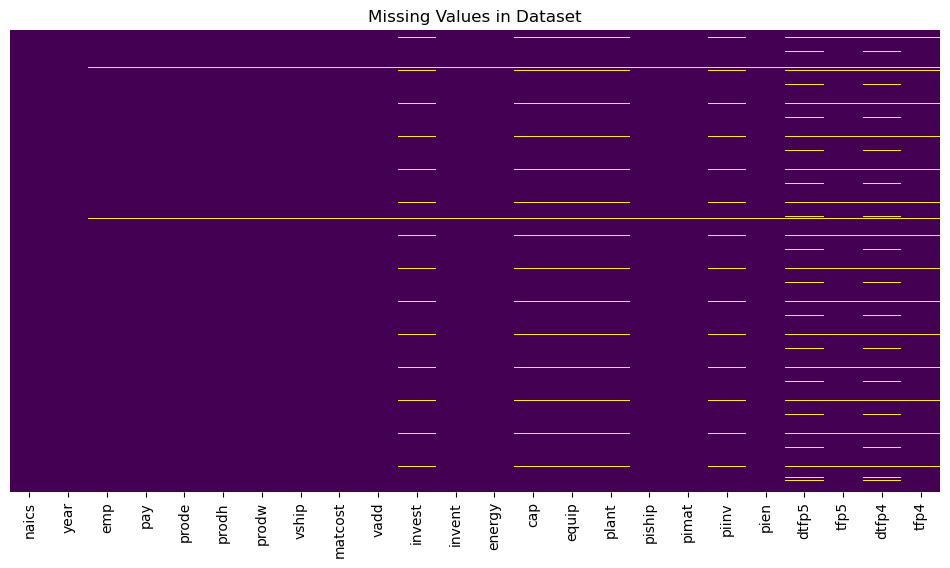

In [4]:
# %%
# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values in Dataset")
plt.show()

In [5]:
# %%
# Step 1: Convert NAICS Codes to String and Filter for Manufacturing (31-33)
df["naics"] = df["naics"].astype(str)
df = df[df["naics"].str.startswith(("31", "32", "33"))].copy()

# Step 2: Define Core Manufacturing Subcategories (Excluding 323 & 324)
core_manufacturing_subcategories = {
    "311": "Food Manufacturing",
    "312": "Beverage & Tobacco Product Manufacturing",
    "313": "Textile Mills",
    "314": "Textile Product Mills",
    "315": "Apparel Manufacturing",
    "316": "Leather & Allied Product Manufacturing",
    "321": "Wood Product Manufacturing",
    "322": "Paper Manufacturing",
    "325": "Chemical Manufacturing",
    "326": "Plastics & Rubber Products Manufacturing",
    "327": "Nonmetallic Mineral Product Manufacturing",
    "331": "Primary Metal Manufacturing",
    "332": "Fabricated Metal Product Manufacturing",
    "333": "Machinery Manufacturing",
    "334": "Computer & Electronic Product Manufacturing",
    "335": "Electrical Equipment, Appliance & Component Manufacturing",
    "336": "Transportation Equipment Manufacturing",
    "337": "Furniture & Related Product Manufacturing",
    "339": "Miscellaneous Manufacturing"
}

# Step 3: Assign Subcategories Based on NAICS Prefix
df["Subcategory"] = df["naics"].str[:3].map(core_manufacturing_subcategories)

# Step 4: Remove Non-Core Manufacturing Categories (Rows where Subcategory is NaN)
df = df.dropna(subset=["Subcategory"])

# Reset index for clean output
df.reset_index(drop=True, inplace=True)


In [6]:
# Define feature and target variables
features = ['emp', 'pay', 'prode', 'invest', 'cap', 'matcost', 'vadd', 'prodh', 'prodw', 'energy', 'invent']
targets = ['dtfp5', 'dtfp4', 'tfp5', 'tfp4']
macro_cols = ['piship', 'pimat', 'piinv', 'pien']
moderate_missing_cols = ['invest', 'cap', 'equip', 'plant']

# Unique NAICS Groups
unique_naics = df['naics'].unique()

# Iterate Over Each NAICS Group
for naics_code in unique_naics:
    subset_df = df[df['naics'] == naics_code].copy()

    # 1️⃣ Handle Moderate Missingness with Rolling Median (Safe for Small Groups)
    window_size = min(len(subset_df), 5)
    subset_df[moderate_missing_cols] = subset_df[moderate_missing_cols].rolling(window_size, min_periods=1).median()
    subset_df[moderate_missing_cols] = subset_df[moderate_missing_cols].fillna(subset_df[moderate_missing_cols].median())

    # 2️⃣ Apply Interpolation for Continuous Trends
    continuous_cols = features + macro_cols + ['vship']  # vship only for interpolation, not training
    subset_df[continuous_cols] = subset_df[continuous_cols].interpolate(method='linear').ffill().bfill()

    # Handle potential spline failures with a try-except block
    for col in continuous_cols:
        try:
            if subset_df[col].count() >= 4:
                subset_df[col] = subset_df[col].interpolate(method='spline', order=3)
        except ValueError:
            pass  # Fall back to linear interpolation

    # 3️⃣ Predict Missing Values using RandomForest
    train_data = subset_df.dropna(subset=targets + features, how='any')

    if not train_data.empty:
        for target in targets:
            if subset_df[target].isna().sum() > 0:
                rf = RandomForestRegressor(n_estimators=100, random_state=42)

                # Ensure no missing values in features before training
                feature_filled = subset_df[features].fillna(subset_df[features].median())

                # Train only on non-missing target rows
                rf.fit(train_data[features], train_data[target])

                # Predict only for missing target values
                missing_rows = subset_df[subset_df[target].isna() & feature_filled.notnull().all(axis=1)]
                if not missing_rows.empty:
                    subset_df.loc[missing_rows.index, target] = rf.predict(missing_rows[features])

    # 4️⃣ Apply KNN Imputation (Only on Features First)
    knn_imputer = KNNImputer(n_neighbors=5)

    # Fill only feature columns first
    subset_df[features] = knn_imputer.fit_transform(subset_df[features])

    # If targets still have missing values, apply KNN on them too
    if subset_df[targets].isnull().sum().sum() > 0:
        subset_df[targets] = knn_imputer.fit_transform(subset_df[targets])

    # 5️⃣ Assign Processed Data Back to Main DataFrame Efficiently
    df.loc[df['naics'] == naics_code, targets + features] = subset_df[targets + features]

# 6️⃣ **Final Global Fallback (Ensures No NaNs)**
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)

# 🚀 Display total remaining NaNs
total_nans = df.isnull().sum().sum()
print(f"🚀 Total Remaining Missing Values: {total_nans}")

# Verify missing values per column
print("Final Missing Values:\n", df.isnull().sum())

🚀 Total Remaining Missing Values: 0
Final Missing Values:
 naics          0
year           0
emp            0
pay            0
prode          0
prodh          0
prodw          0
vship          0
matcost        0
vadd           0
invest         0
invent         0
energy         0
cap            0
equip          0
plant          0
piship         0
pimat          0
piinv          0
pien           0
dtfp5          0
tfp5           0
dtfp4          0
tfp4           0
Subcategory    0
dtype: int64


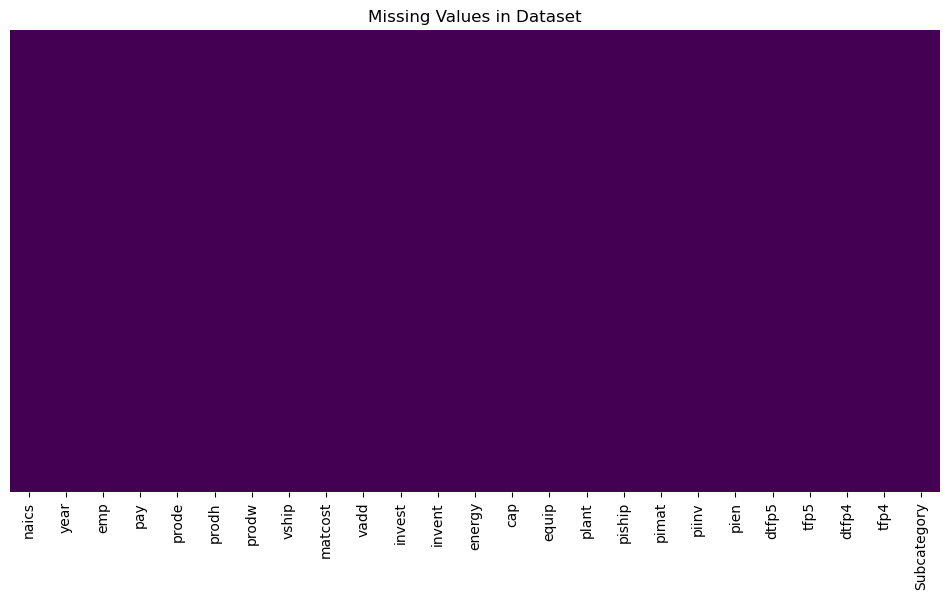

In [7]:
# %%
# df.drop(columns=['naics'], inplace=True)

# %%
# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values in Dataset")
plt.show()


In [8]:
# %%
# Check for missing values
missing_values = df.isnull().sum()

print(missing_values)

naics          0
year           0
emp            0
pay            0
prode          0
prodh          0
prodw          0
vship          0
matcost        0
vadd           0
invest         0
invent         0
energy         0
cap            0
equip          0
plant          0
piship         0
pimat          0
piinv          0
pien           0
dtfp5          0
tfp5           0
dtfp4          0
tfp4           0
Subcategory    0
dtype: int64


/tmp/ipykernel_38650/3500437902.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)


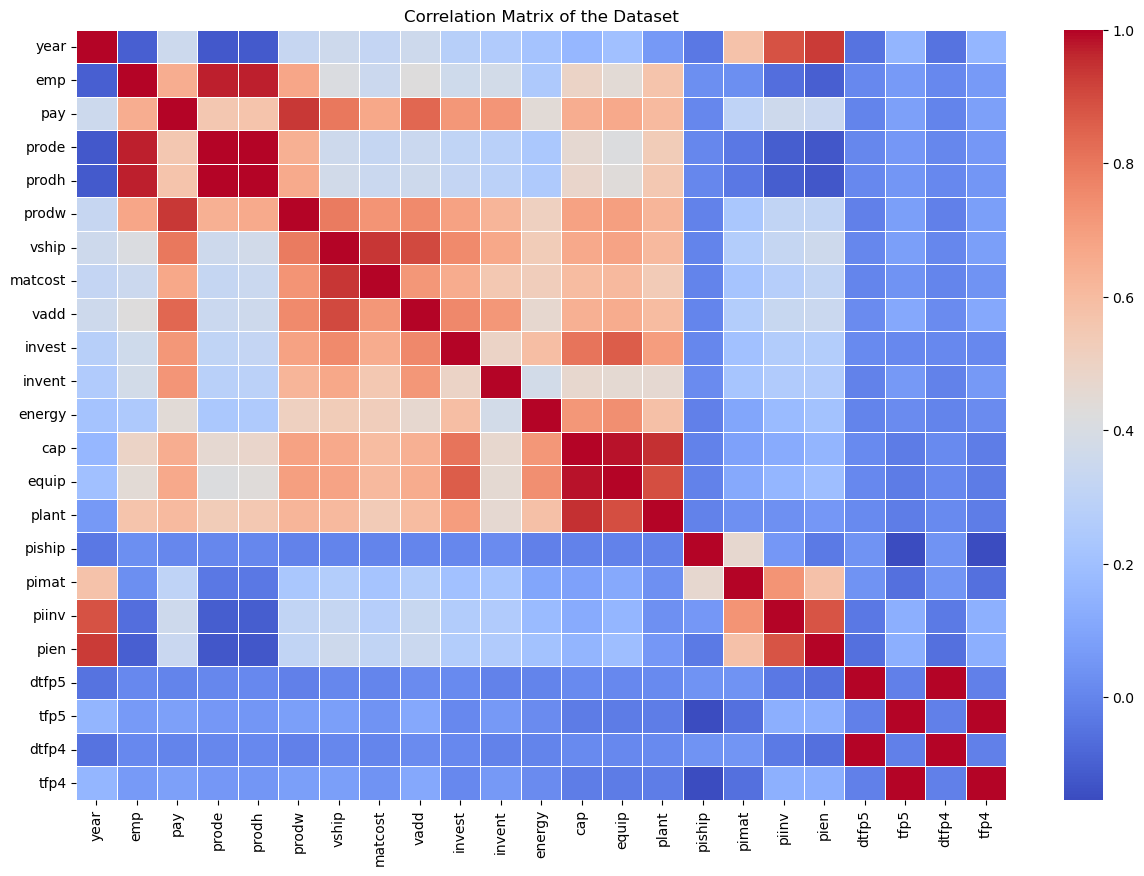

In [9]:
# %%
# Correlation Matrix
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of the Dataset")
plt.show()

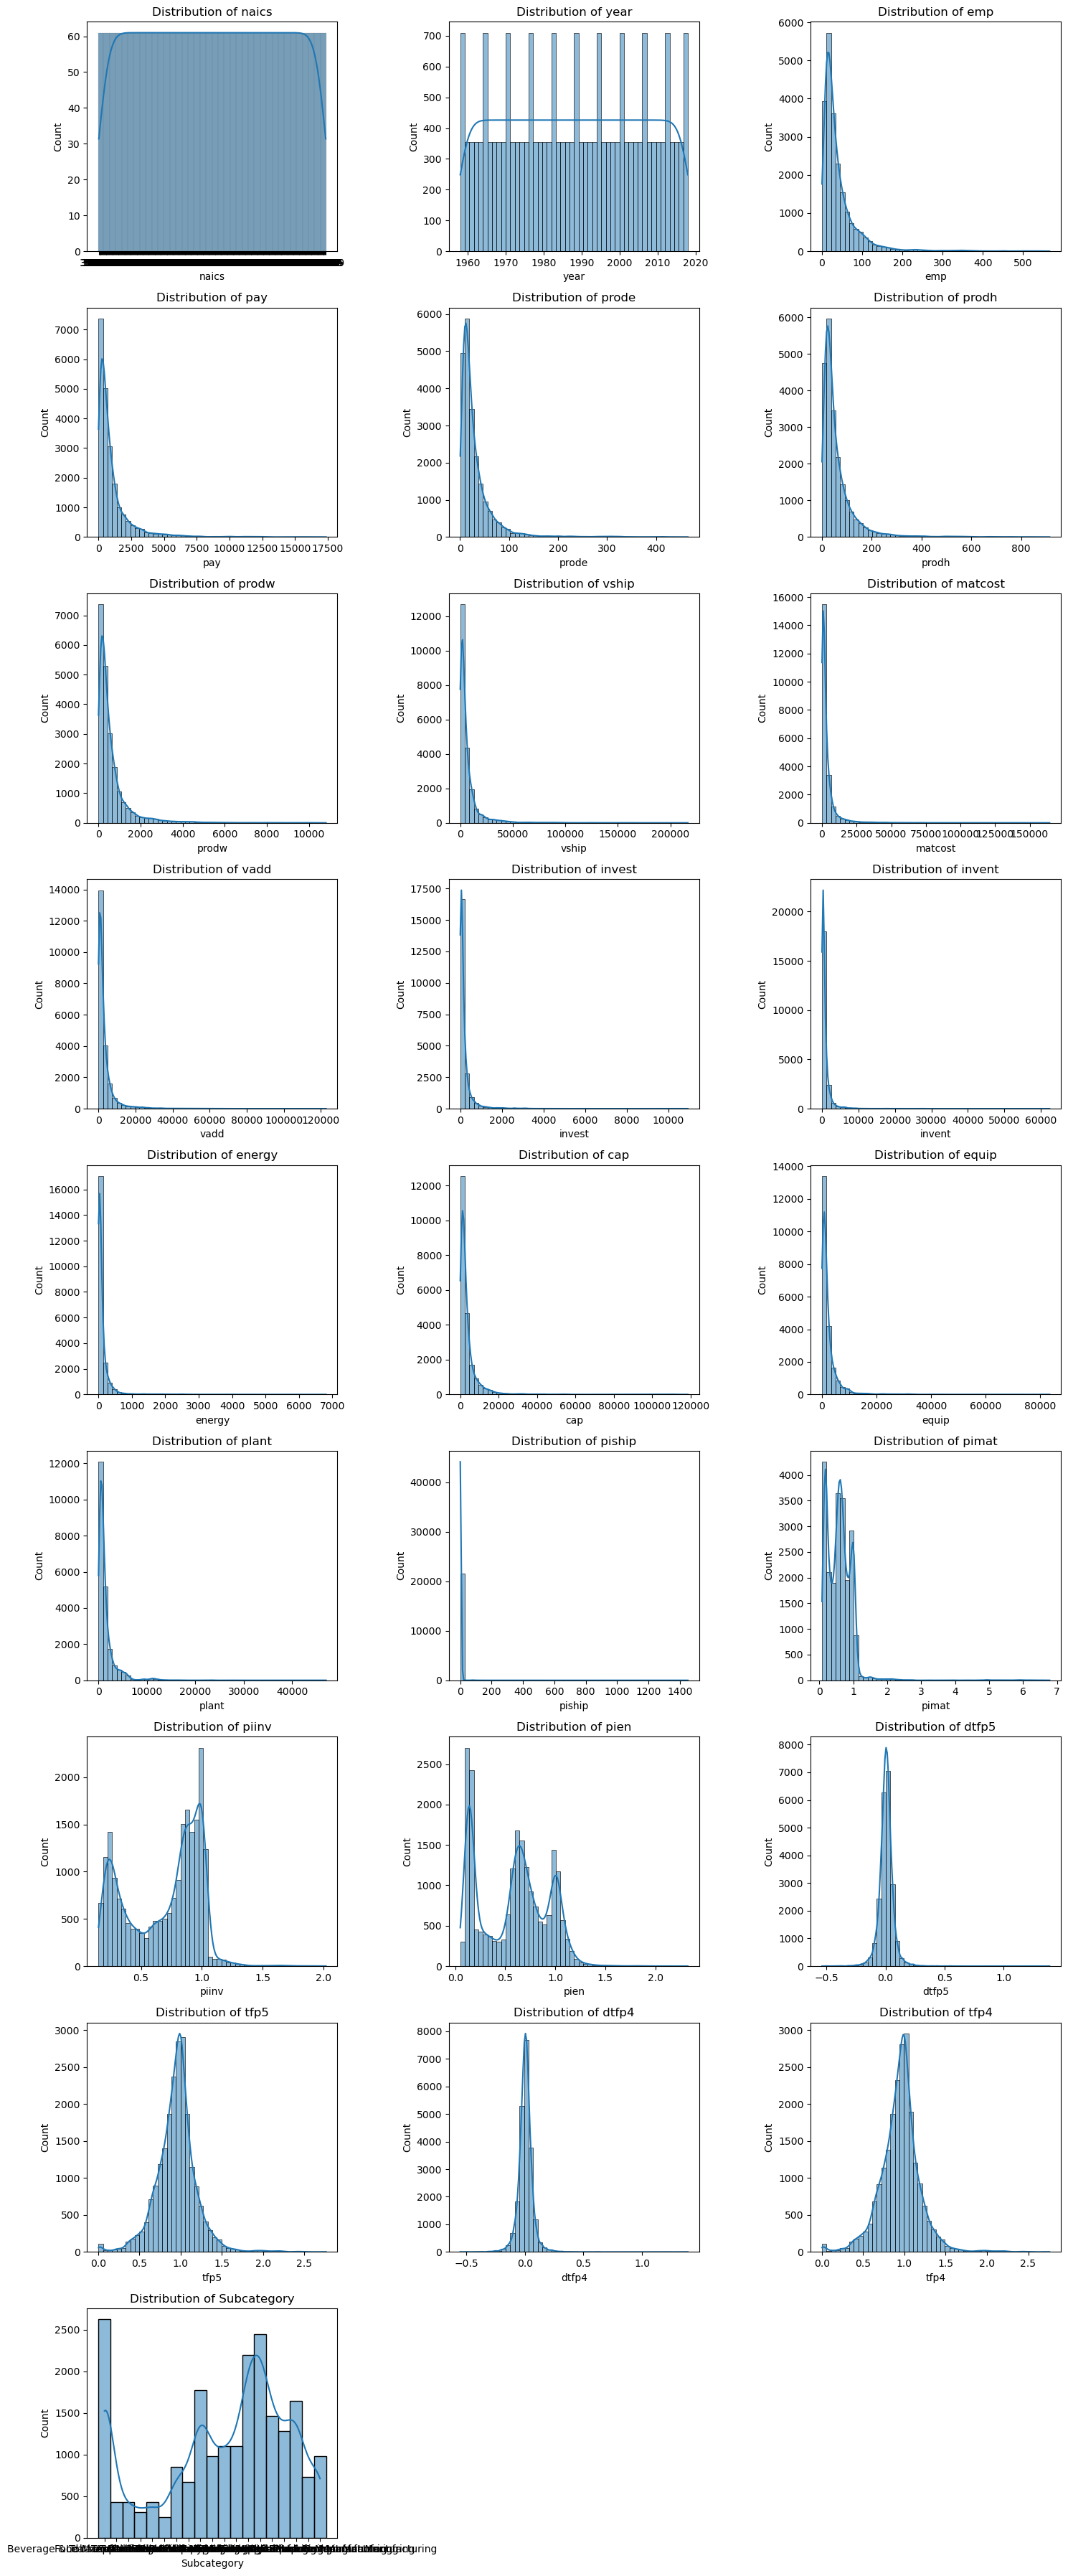

In [10]:
# %%
def plot_feature_distributions(df, max_cols=3):
    """
    Plots histograms for all columns in the dataframe.
    
    Parameters:
        df (pd.DataFrame): The dataframe containing features to plot.
        max_cols (int): Maximum number of columns per row in the subplot grid.
    """
    num_features = len(df.columns)
    num_rows = math.ceil(num_features / max_cols)  # Calculate required rows

    plt.figure(figsize=(max_cols * 5, num_rows * 4))  # Adjust figure size dynamically

    for i, feature in enumerate(df.columns, 1):
        plt.subplot(num_rows, max_cols, i)
        sns.histplot(df[feature].dropna(), bins=50, kde=True)
        plt.title(f"Distribution of {feature}")

    plt.tight_layout()
    plt.show()
plot_feature_distributions(df, max_cols=3)


In [11]:
df.skew()


/tmp/ipykernel_38650/547062910.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew()


naics      -0.710232
year        0.000000
emp         3.951763
pay         4.179270
prode       4.564380
prodh       4.355162
prodw       4.239200
vship       5.729817
matcost     7.014962
vadd        7.324903
invest      9.584905
invent     13.838729
energy      8.403680
cap         8.038383
equip       7.920075
plant       8.297585
piship     31.987751
pimat       5.155210
piinv      -0.326169
pien        0.043110
dtfp5       1.073698
tfp5        0.288587
dtfp4       1.061352
tfp4        0.275369
dtype: float64

In [12]:
def preprocess_nans(df, strategy='median'):
    """
    Handles NaN values before transformations.

    Parameters:
    - df (pd.DataFrame): Input dataframe.
    - strategy (str): Method to handle NaNs ('mean', 'median', 'zero').

    Returns:
    - df_filled (pd.DataFrame): Dataframe with NaNs handled.
    - nan_replacements (dict): Dictionary storing replacements for restoration.
    """
    df_filled = df.copy()
    nan_replacements = {}  # Store original NaN locations

    for col in df.select_dtypes(include=[np.number]).columns:  # Apply only to numeric columns
        if df[col].isna().sum() > 0:
            if strategy == 'median':
                fill_value = df[col].median()
            elif strategy == 'mean':
                fill_value = df[col].mean()
            else:  # Zero filling
                fill_value = 0

            fill_value = fill_value if not np.isnan(fill_value) else 0  # Handle edge case
            df_filled[col].fillna(fill_value, inplace=True)
            nan_replacements[col] = fill_value  # Store for later restoration

    return df_filled, nan_replacements


def transform_skewed_features(df, exclude_columns=None):
    """
    Transforms skewed features while excluding specified columns.
    Handles NaNs before transformation.

    Parameters:
    - df (pd.DataFrame): Input dataframe.
    - exclude_columns (list, optional): Columns to exclude from transformations.

    Returns:
    - df_transformed (pd.DataFrame): Transformed dataframe.
    - transformations (dict): Dictionary of applied transformations.
    - nan_replacements (dict): Dictionary storing NaN replacements.
    """
    if exclude_columns is None:
        exclude_columns = []

    df_cleaned, nan_replacements = preprocess_nans(df)  # Handle NaNs first
    df_transformed = df_cleaned.copy()
    transformations = {}  # Store transformations

    numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
    skewness = df_cleaned[numeric_cols].skew()

    columns_to_transform = [col for col in numeric_cols if col not in exclude_columns]

    for col in columns_to_transform:
        min_val = df_cleaned[col].min()

        if skewness[col] > 3 or skewness[col] < -3:  # EXTREME skewness
            shift = abs(min_val) + 1 if min_val <= 0 else 0  # Ensure positivity
            df_transformed[col] = np.log1p(df_transformed[col] + shift)
            transformations[col] = ('log1p_shift', shift)
        
        elif 1.5 < abs(skewness[col]) <= 3:  # MODERATE skewness
            df_transformed[col] = np.cbrt(df_transformed[col])
            transformations[col] = ('cbrt', None)

        elif 0.5 < abs(skewness[col]) <= 1.5:  # MILD skewness
            shift = abs(min_val) if min_val < 0 else 0
            df_transformed[col] = np.sqrt(df_transformed[col] + shift)
            transformations[col] = ('sqrt_shift', shift)

    return df_transformed, transformations, nan_replacements


def restore_original_values(df_transformed, transformations, nan_replacements):
    """
    Restores transformed values to their original scale and reintroduces NaNs.

    Parameters:
    - df_transformed (pd.DataFrame): Transformed dataframe.
    - transformations (dict): Mapping of column names to transformations.
    - nan_replacements (dict): Original NaN replacements.

    Returns:
    - df_original (pd.DataFrame): Restored dataframe.
    """
    df_original = df_transformed.copy()
    
    for col, transform in transformations.items():
        if transform[0] == 'log1p_shift':
            df_original[col] = np.expm1(df_original[col]) - transform[1]  # Undo shift
            df_original[col] = np.round(df_original[col], 6)  # Reduce floating-point error
        
        elif transform[0] == 'cbrt':
            df_original[col] = np.power(df_original[col], 3)  # Inverse of cube root
            df_original[col] = np.round(df_original[col], 6)  # Reduce floating-point error
        
        elif transform[0] == 'sqrt_shift':
            df_original[col] = (df_original[col] ** 2) - transform[1]  # Undo shift
            df_original[col] = np.round(df_original[col], 6)  # Reduce floating-point error

    # Restore NaNs safely using a mask instead of direct replacement
    for col, fill_value in nan_replacements.items():
        df_original[col] = df_original[col].mask(np.isclose(df_original[col], fill_value, atol=1e-6), np.nan)  

    return df_original

In [13]:
# %%
# Step 1: Transform Data (including handling NaNs)
df_transformed, transformations, nan_replacements = transform_skewed_features(df)

print(nan_replacements)
# Step 2: Restore to Original Values
df_original = restore_original_values(df_transformed, transformations, nan_replacements)


{}


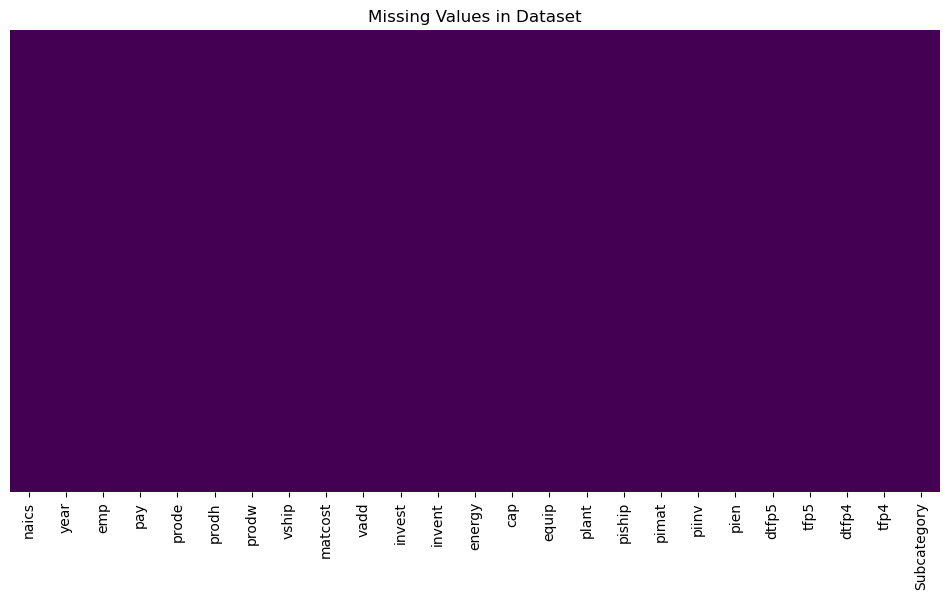

In [14]:
# Visualizing missing values
plt.figure(figsize=(12, 6))
sns.heatmap(df_transformed.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Missing Values in Dataset")
plt.show()

In [15]:
# Ensure only numeric columns are compared
numeric_df = df.select_dtypes(include=[np.number]).fillna(0)
numeric_df_original = df_original.select_dtypes(include=[np.number]).fillna(0)

# Compare only numeric values
print(np.allclose(numeric_df, numeric_df_original, atol=1e-6))  # Should return True

True


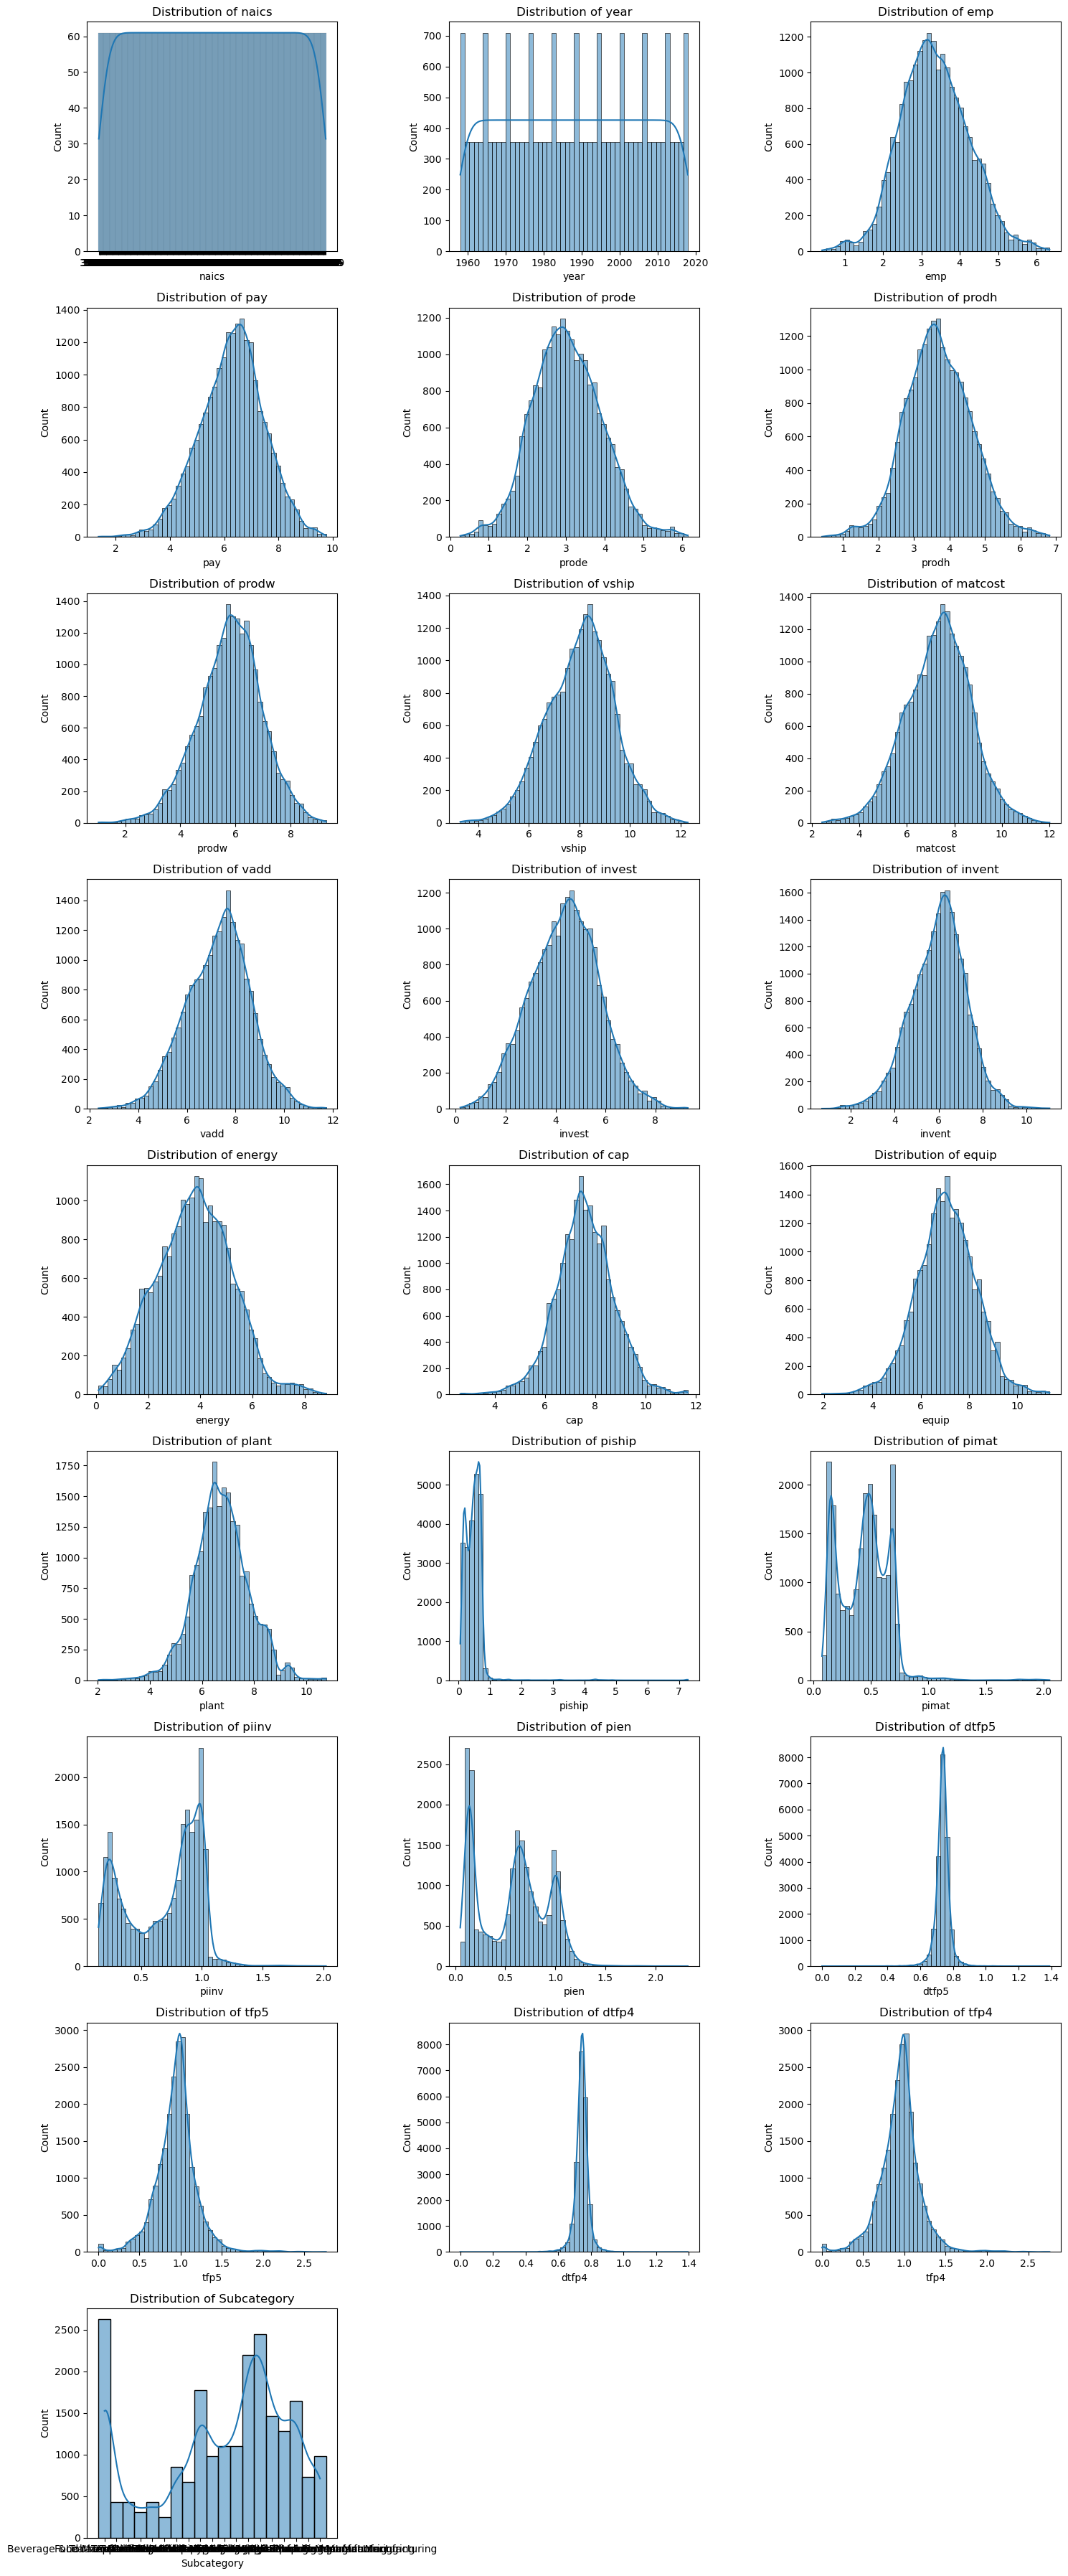

In [16]:
# %%
plot_feature_distributions(df_transformed, max_cols=3)


In [17]:
df_transformed.skew()

/tmp/ipykernel_38650/3832597954.py:1: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_transformed.skew()


naics     -0.710232
year       0.000000
emp        0.154350
pay       -0.213065
prode      0.199497
prodh      0.100914
prodw     -0.235185
vship     -0.177024
matcost   -0.134100
vadd      -0.179238
invest    -0.004430
invent    -0.207807
energy     0.121814
cap       -0.055716
equip     -0.072306
plant      0.021212
piship     8.859258
pimat      0.959522
piinv     -0.326169
pien       0.043110
dtfp5     -0.808710
tfp5       0.288587
dtfp4     -1.019918
tfp4       0.275369
dtype: float64

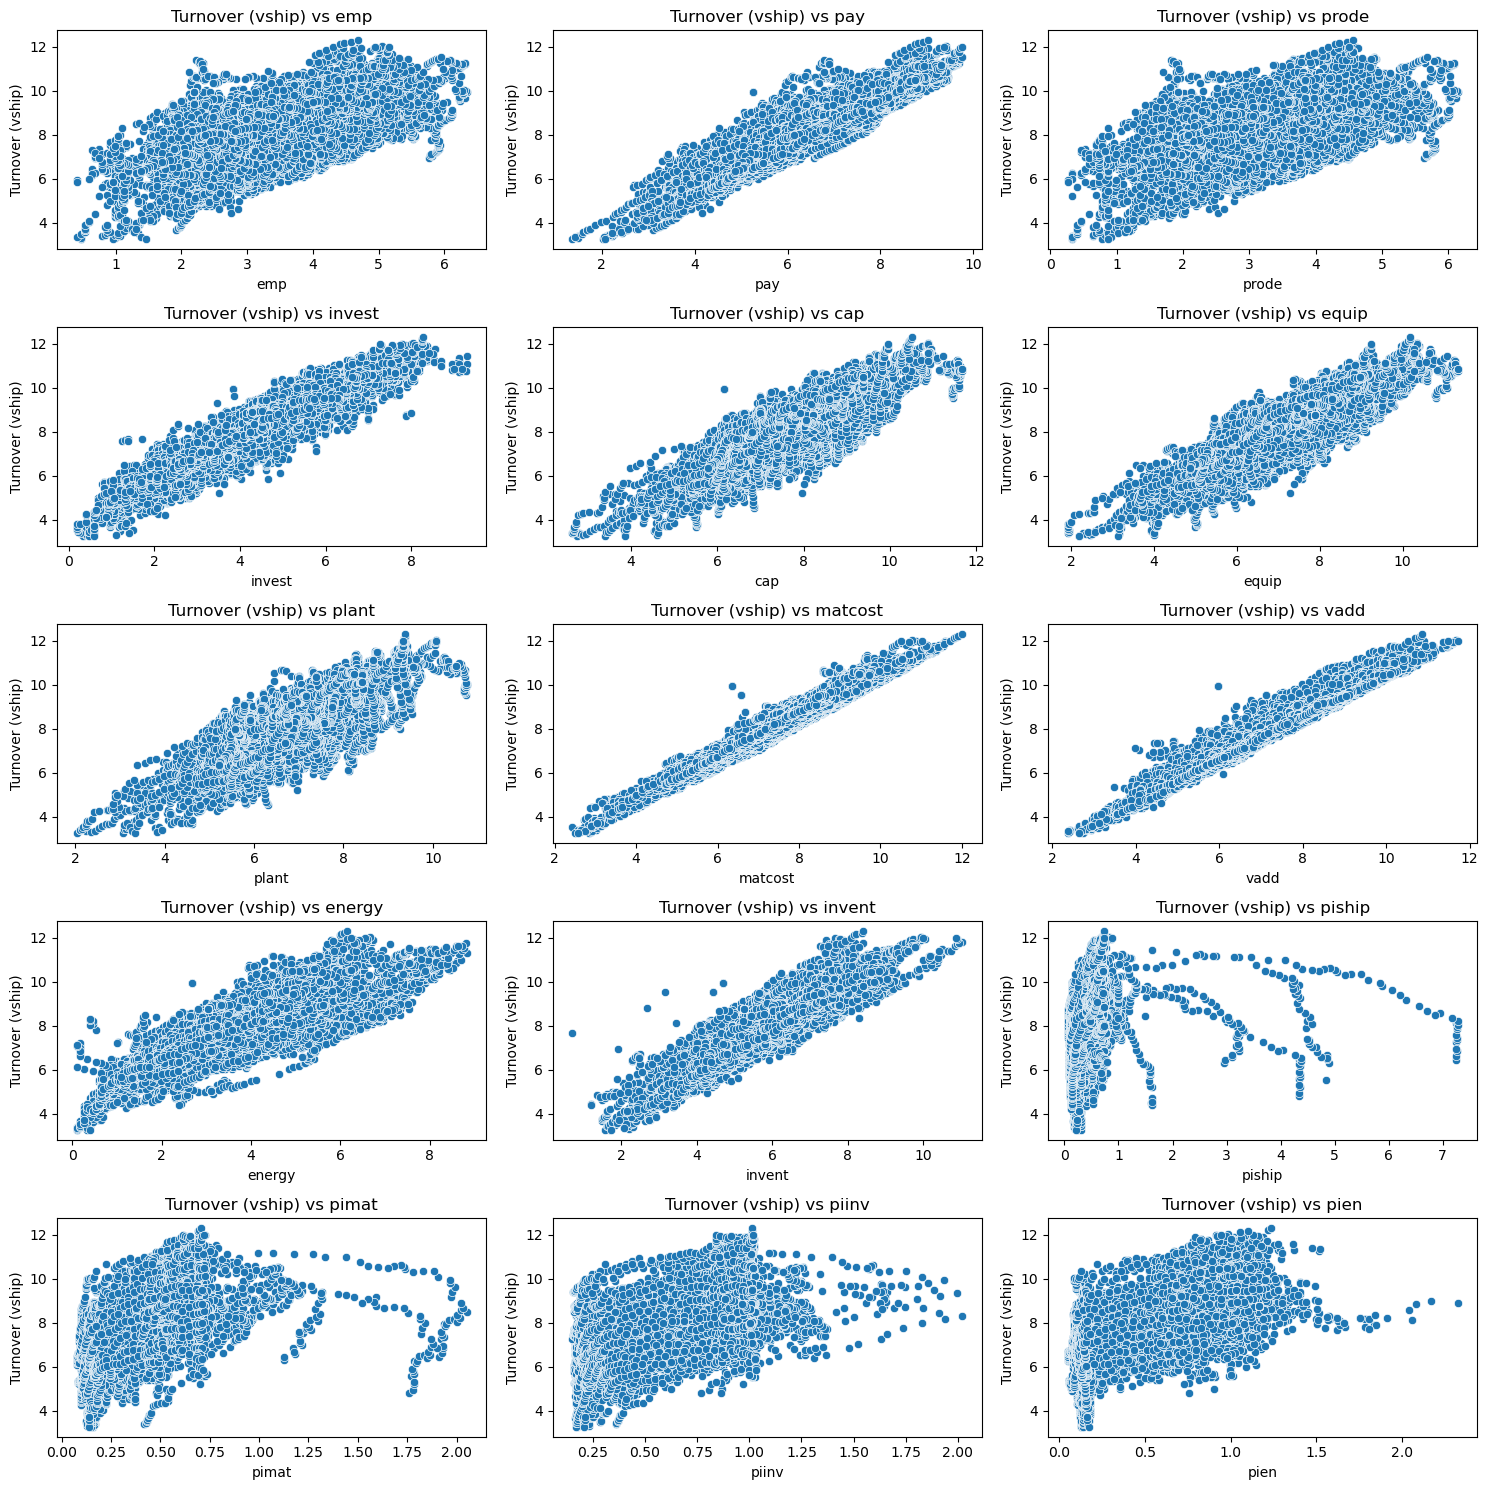

In [18]:
# Define expanded features for scatter plots
relevant_features = ["emp", "pay", "prode", "invest", "cap", "equip", "plant", "matcost", "vadd", "energy", "invent", "piship", "pimat", "piinv", "pien"]

# Set up scatter plot grid
plt.figure(figsize=(15, 15))
for i, feature in enumerate(relevant_features, 1):
    plt.subplot(5, 3, i)  # 5 rows, 3 columns of subplots
    sns.scatterplot(x=df_transformed[feature], y=df_transformed["vship"])
    plt.title(f"Turnover (vship) vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("Turnover (vship)")

plt.tight_layout()
plt.show()


In [19]:
df.Subcategory.value_counts()


Food Manufacturing                                           2623
Machinery Manufacturing                                      2440
Fabricated Metal Product Manufacturing                       2196
Chemical Manufacturing                                       1769
Transportation Equipment Manufacturing                       1647
Computer & Electronic Product Manufacturing                  1464
Electrical Equipment, Appliance & Component Manufacturing    1281
Primary Metal Manufacturing                                  1098
Nonmetallic Mineral Product Manufacturing                    1098
Miscellaneous Manufacturing                                   976
Plastics & Rubber Products Manufacturing                      976
Wood Product Manufacturing                                    854
Furniture & Related Product Manufacturing                     732
Paper Manufacturing                                           671
Beverage & Tobacco Product Manufacturing                      427
Textile Mi

In [20]:
df.head()

,naics,year,emp,pay,prode,prodh,prodw,vship,matcost,vadd,...,plant,piship,pimat,piinv,pien,dtfp5,tfp5,dtfp4,tfp4,Subcategory
0,311111,1958,18.0,81.3,12.0,25.7,49.8,1042.4,752.4,266.9,...,695.0,0.354,0.133,0.168,0.116,0.1316,0.317,0.13102,0.318,Food Manufacturing
1,311111,1959,17.9,82.5,11.8,25.5,49.4,1051.0,758.9,268.7,...,725.3,0.345,0.131,0.169,0.115,0.0020,0.318,0.00200,0.318,Food Manufacturing
2,311111,1960,17.7,84.8,11.7,25.4,50.0,1050.2,752.8,269.9,...,739.2,0.274,0.129,0.173,0.119,0.2170,0.394,0.21600,0.395,Food Manufacturing
3,311111,1961,17.5,87.4,11.5,25.4,51.4,1119.7,803.6,287.8,...,752.0,0.273,0.131,0.172,0.117,0.0240,0.404,0.02400,0.405,Food Manufacturing
4,311111,1962,17.6,90.2,11.5,25.2,52.1,1175.7,853.3,294.5,...,768.7,0.277,0.132,0.174,0.119,-0.0070,0.401,-0.00700,0.402,Food Manufacturing


In [21]:
# One-hot encoding
df_encoded = pd.get_dummies(df, columns=['Subcategory'])

print(df_encoded)

        naics  year   emp     pay  prode  prodh   prodw    vship  matcost  \
0      311111  1958  18.0    81.3   12.0   25.7    49.8   1042.4    752.4   
1      311111  1959  17.9    82.5   11.8   25.5    49.4   1051.0    758.9   
2      311111  1960  17.7    84.8   11.7   25.4    50.0   1050.2    752.8   
3      311111  1961  17.5    87.4   11.5   25.4    51.4   1119.7    803.6   
4      311111  1962  17.6    90.2   11.5   25.2    52.1   1175.7    853.3   
...       ...   ...   ...     ...    ...    ...     ...      ...      ...   
21650  339999  2014  58.3  2657.0   35.5   67.6  1167.7  13857.3   5213.5   
21651  339999  2015  58.5  2738.9   34.6   66.7  1190.0  13848.1   5018.4   
21652  339999  2016  57.2  2807.3   34.3   65.7  1255.5  13997.7   4981.3   
21653  339999  2017  49.1  2381.6   32.5   60.3  1259.4  11981.0   4404.1   
21654  339999  2018  53.6  2654.2   35.0   60.2  1327.6  13153.5   4750.1   

         vadd  ...  Subcategory_Machinery Manufacturing  \
0       266.9  .

In [22]:
import pandas as pd
import numpy as np

def time_series_split_by_year(df, time_col, stratify_col, test_ratio=0.2):
    """
    Splits each NAICS category while keeping the last `test_ratio` proportion of years as test data.

    Parameters:
        df (pd.DataFrame): The input dataframe.
        time_col (str): The name of the time column.
        stratify_col (str): The column to stratify by (e.g., 'naics').
        test_ratio (float): The proportion of years to use for testing (e.g., 0.2 for 20%).

    Returns:
        train_df (pd.DataFrame): Training dataset.
        test_df (pd.DataFrame): Testing dataset.
    """
    train_list, test_list = [], []

    for group_id, group in df.groupby(stratify_col):  # Group by NAICS
        group = group.sort_values(by=time_col).reset_index(drop=True)  # Ensure correct order
        unique_years = sorted(group[time_col].unique())  # Get unique years in ascending order
        
        num_test_years = max(1, int(len(unique_years) * test_ratio))  # Ensure at least one year is in test
        test_years = unique_years[-num_test_years:]  # Select the last 20% of years
        
        train_list.append(group[~group[time_col].isin(test_years)])  # Train: exclude test years
        test_list.append(group[group[time_col].isin(test_years)])  # Test: only last 20% years

    return pd.concat(train_list, ignore_index=True), pd.concat(test_list, ignore_index=True)

# Apply the function
train_df, test_df = time_series_split_by_year(df_encoded, time_col='year', stratify_col='naics', test_ratio=0.2)

# Verify the split
print("\nTrain Set Years Range:", train_df['year'].min(), "to", train_df['year'].max())
print("Test Set Years Range:", test_df['year'].min(), "to", test_df['year'].max())

# Check stratification (each NAICS should be preserved)
print("\nTrain NAICS Distribution:\n", train_df['naics'].value_counts(normalize=True))
print("\nTest NAICS Distribution:\n", test_df['naics'].value_counts(normalize=True))



Train Set Years Range: 1958 to 2006
Test Set Years Range: 2007 to 2018

Train NAICS Distribution:
 339999    0.002817
311111    0.002817
311119    0.002817
336411    0.002817
336412    0.002817
            ...   
311224    0.002817
311225    0.002817
311230    0.002817
311313    0.002817
311314    0.002817
Name: naics, Length: 355, dtype: float64

Test NAICS Distribution:
 339999    0.002817
311111    0.002817
311119    0.002817
336411    0.002817
336412    0.002817
            ...   
311224    0.002817
311225    0.002817
311230    0.002817
311313    0.002817
311314    0.002817
Name: naics, Length: 355, dtype: float64


: 

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tqdm import tqdm
import warnings
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings("ignore")

# Define Model Evaluation Metrics
def evaluate_forecast(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {"RMSE": rmse, "MAPE": mape}

# Function to perform Time Series Cross-Validation without NAICS stratification
def time_series_cross_validation(df, target_col, time_col, max_lags=3, n_splits=5):
    """
    Performs Time Series Cross-Validation on the entire dataset (No NAICS grouping).

    Parameters:
        df (pd.DataFrame): Input dataframe.
        target_col (str): Name of the target column.
        time_col (str): Name of the time column.
        max_lags (int): Number of lag observations to use.
        n_splits (int): Number of time-based splits for cross-validation.

    Returns:
        results_df (pd.DataFrame): RMSE and MAPE for each model.
    """
    df = df.sort_values(by=time_col).reset_index(drop=True)  # Ensure chronological order
    df = df.drop(columns=["naics"], errors="ignore")  # Remove NAICS column if present

    results = []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for train_index, test_index in tqdm(tscv.split(df), desc="Processing Splits"):
        train, test = df.iloc[train_index], df.iloc[test_index]
        y_train, y_test = train[target_col], test[target_col]

        # Naïve Forecast (Last Observation)
        naive_forecast = y_train.iloc[-1]
        naive_pred = np.full(len(y_test), naive_forecast)
        naive_metrics = evaluate_forecast(y_test, naive_pred)
        results.append(["Naïve", naive_metrics["RMSE"], naive_metrics["MAPE"]])

        # Moving Average Forecast (Mean of last `max_lags` values)
        if len(y_train) >= max_lags:
            moving_avg_forecast = y_train.iloc[-max_lags:].mean()
            moving_avg_pred = np.full(len(y_test), moving_avg_forecast)
            moving_avg_metrics = evaluate_forecast(y_test, moving_avg_pred)
            results.append(["Moving Average", moving_avg_metrics["RMSE"], moving_avg_metrics["MAPE"]])

        # Autoregressive Model (AR)
        if len(y_train) > max_lags:
            ar_model = AutoReg(y_train, lags=max_lags).fit()
            ar_pred = ar_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
            ar_metrics = evaluate_forecast(y_test, ar_pred)
            results.append(["AR", ar_metrics["RMSE"], ar_metrics["MAPE"]])

        # ARIMA Model (p=1, d=1, q=1)
        try:
            arima_model = ARIMA(y_train, order=(1, 1, 1)).fit()
            arima_pred = arima_model.forecast(steps=len(y_test))
            arima_metrics = evaluate_forecast(y_test, arima_pred)
            results.append(["ARIMA(1,1,1)", arima_metrics["RMSE"], arima_metrics["MAPE"]])
        except:
            pass

        # Seasonal ARIMA (SARIMA) - (1,1,1)(1,1,1,12)
        try:
            sarima_model = SARIMAX(y_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit(disp=False)
            sarima_pred = sarima_model.forecast(steps=len(y_test))
            sarima_metrics = evaluate_forecast(y_test, sarima_pred)
            results.append(["SARIMA(1,1,1)(1,1,1,12)", sarima_metrics["RMSE"], sarima_metrics["MAPE"]])
        except:
            pass

        # Vector Autoregression (VAR) - Only if multiple features exist
        if len(train.columns) > 2:  # Ensure there are exogenous variables
            try:
                var_model = VAR(train.drop(columns=[time_col]))
                var_result = var_model.fit(maxlags=max_lags)
                var_pred = var_result.forecast(y=train.drop(columns=[time_col]).values[-max_lags:], steps=len(y_test))
                var_metrics = evaluate_forecast(y_test, var_pred[:, 0])  # Assuming target is first column
                results.append(["VAR", var_metrics["RMSE"], var_metrics["MAPE"]])
            except:
                pass

    results_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAPE"])
    return results_df

# Apply TSCV on Entire Dataset (No NAICS)
results_df = time_series_cross_validation(df_encoded, target_col="vship", time_col="year")

# Display Results



Processing Splits: 4it [01:36, 26.24s/it]

In [25]:
results_df.head()

,Model,NAICS,RMSE,MAPE
0,Naïve,311111,713.782537,0.245781
1,Moving Average,311111,735.943115,0.256907
2,AR,311111,352.084824,0.155264
3,"ARIMA(1,1,1)",311111,741.802906,0.259171
4,"SARIMA(1,1,1)(1,1,1,12)",311111,398.158255,0.184904
